In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from guided_diffusion.image_datasets import load_data
sys.path.insert(0, '/home/sclocchi')
from local_probability_models_of_images.code.wavelet_func import multi_scale_decompose
# from local_probability_models_of_images.code.model_loader_func import load_multi_scale_denoisers_RF, load_BF_CNN_RF
# from local_probability_models_of_images.code.wavelet_func import multi_scale_denoising, multi_scale_identity_denoising,multi_scale_decompose

In [14]:
starting_data_dir = '../datasets/ILSVRC2012/validation'

data_start = load_data(
    data_dir=starting_data_dir,
    batch_size=8,
    image_size=256,
    deterministic=True,
    class_cond=True,
    random_crop=False,
    random_flip=False,
)

In [15]:
batch_start, extra = next(data_start)
batch_start.shape

torch.Size([8, 3, 256, 256])

In [34]:
n = 0
clean_coeffs = multi_scale_decompose(batch_start[n:n+1], J = 8, device=batch_start.device)

In [35]:
for coeff in clean_coeffs:
    print(coeff.shape)
# clean_coeffs[0].shape

torch.Size([1, 12, 128, 128])
torch.Size([1, 12, 64, 64])
torch.Size([1, 12, 32, 32])
torch.Size([1, 12, 16, 16])
torch.Size([1, 12, 8, 8])
torch.Size([1, 12, 4, 4])
torch.Size([1, 12, 2, 2])
torch.Size([1, 12, 1, 1])


In [75]:
batch_start[n].min()

tensor(-1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


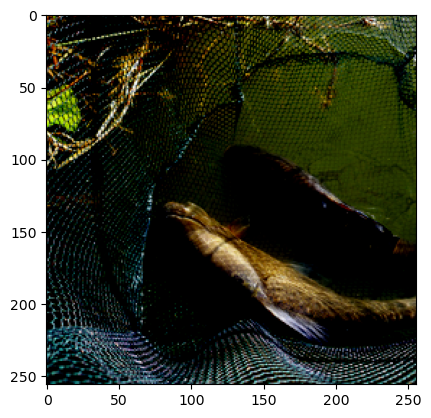

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


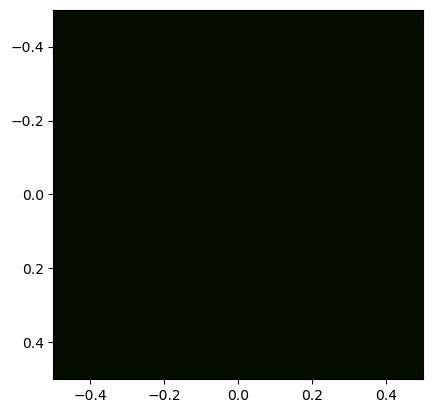

In [72]:
plt.imshow(batch_start[n].permute(1, 2, 0).cpu().numpy())
plt.show()
kk = 0
plt.imshow(clean_coeffs[7][0][kk:kk+3].permute(1, 2, 0).cpu().numpy())
# plt.imshow(clean_coeffs[0].norm(dim=1).squeeze().cpu().numpy())

In [80]:
import pywt

low, high = pywt.dwt2(batch_start[n:n+1], wavelet='db1', mode='symmetric')
low.shape, high[0].shape


((1, 3, 128, 128), (1, 3, 128, 128))

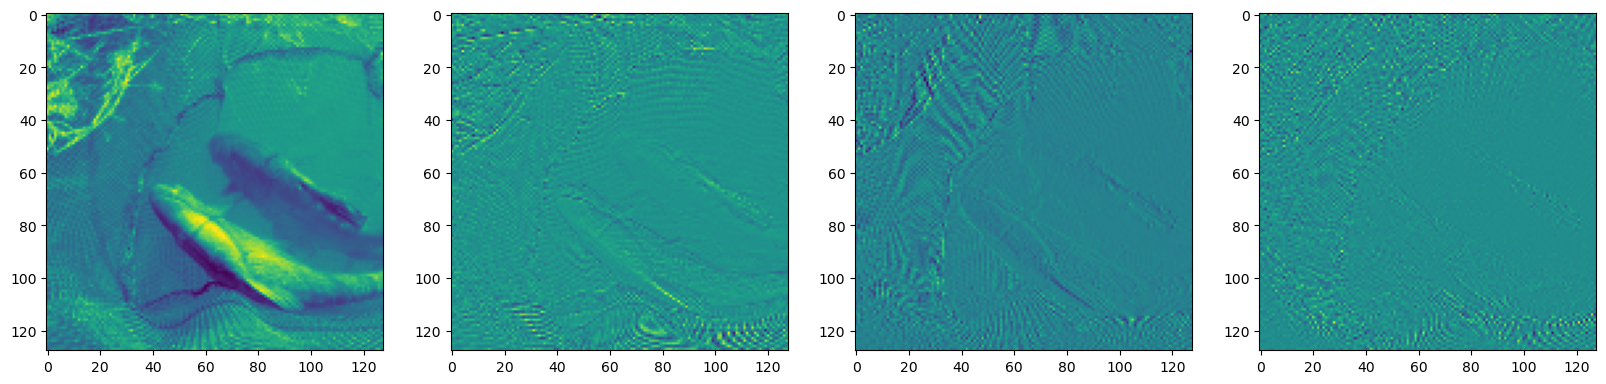

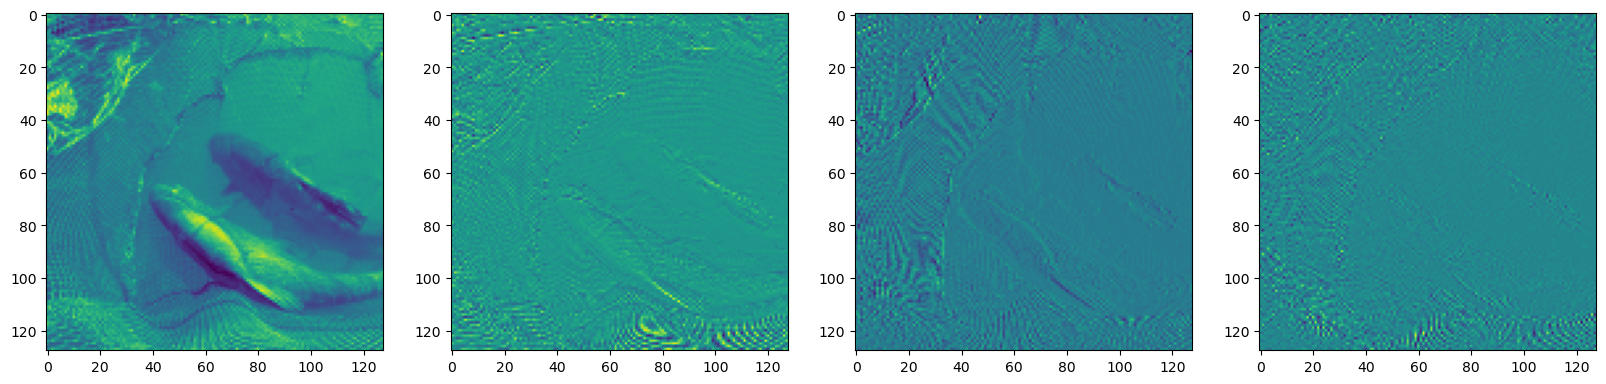

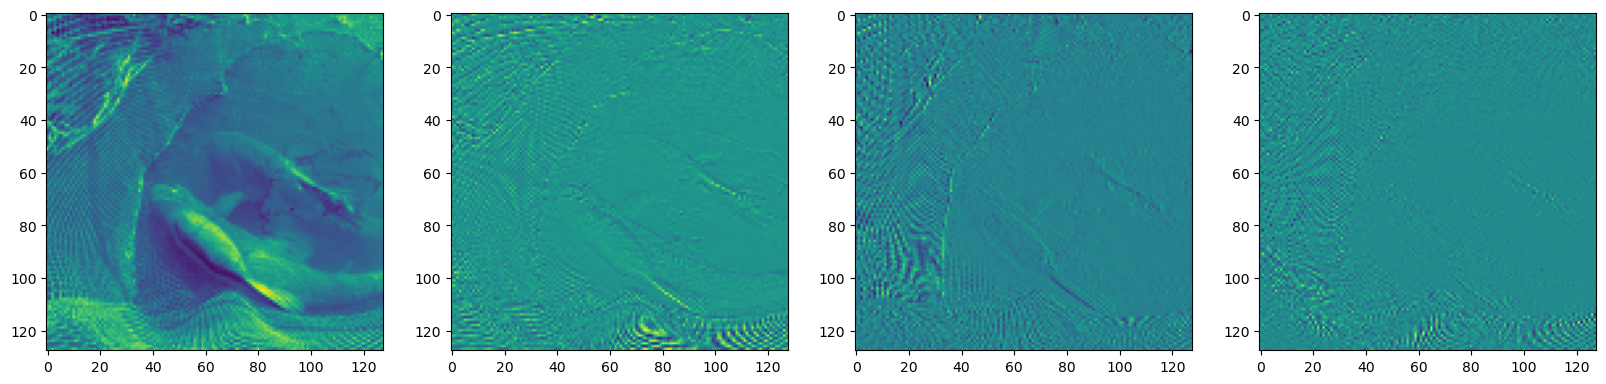

In [85]:
# ch = 0
for ch in [0, 1, 2]:
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(low[0][ch])
    axs[1].imshow(high[0][0][ch])
    axs[2].imshow(high[1][0][ch])
    axs[3].imshow(high[2][0][ch])

    plt.show()


In [70]:
clean_coeffs[7].shape

torch.Size([1, 12, 1, 1])

## File analysis

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

from collections import defaultdict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
file_args = '../datasets/diffused_ILSVRC2012_validation/t_25_250_args_2024-01-19-23-29-10-184671.pk'
with open(file_args, 'rb') as f:
    args = pickle.load(f)
print(args)

_, diffusion = create_model_and_diffusion(
    **args_to_dict(args, model_and_diffusion_defaults().keys())
)

betas = np.array(diffusion.betas)
alpha_bar = np.array(diffusion.alphas_cumprod)

Namespace(clip_denoised=True, num_samples=10000, batch_size=32, use_ddim=False, model_path='models/256x256_diffusion_uncond.pt', image_size=256, num_channels=256, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=64, attention_resolutions='32,16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=True, use_fp16=True, use_new_attention_order=False, learn_sigma=True, diffusion_steps=1000, noise_schedule='linear', timestep_respacing='250', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False, step_reverse=25, data_dir='/scratch/izar/sclocchi/datasets/ILSVRC2012/validation', output='/scratch/izar/sclocchi/guided-diffusion/results/diffused_ILSVRC2012_validation', num_per_class=10, num_classes=1000)


In [4]:
key = 'mean_abs_delta_ck'
# key = 'mean_delta_ck'
values_per_time = {}
lengths_per_time = {}

for t in range(25, 275, 25):
    values_per_time[t] = []
    lengths_per_time[t] = []
    # file = f'../Wavelet_coefficients/diffused_ILSVRC2012_validation/wavelet_coeff-t_{t}_250-norm.pk'
    file = f'../Wavelet_coefficients/diffused_ILSVRC2012_validation/wavelet_coeff-t_{t}_250-complete.pk'

    with open(file, 'rb') as f:
        wavelet_coeff = pickle.load(f)

    # for xx, x0 in zip(wavelet_coeff[key], wavelet_coeff['mean_ck0']):
    # for xx, x0 in zip(wavelet_coeff['mean_norm2_delta_ck'], wavelet_coeff['mean_norm2_ck0']):
    for xx, x0 in zip(wavelet_coeff['mean_abs_delta_ck'], wavelet_coeff['mean_abs_ck0']):
        # values_per_time[t].append(np.linalg.norm(xx, axis=0).mean()/ np.linalg.norm(x0, axis=0).mean())
        # values_per_time[t].append(np.linalg.norm(xx[3:], axis=0).mean()/ np.linalg.norm(x0[3:], axis=0).mean())
        # values_per_time[t].append(np.sum(xx[3:], axis=0).mean()**0.5/ np.sum(x0[3:], axis=0).mean()**0.5)
        values_per_time[t].append((xx[3:]).mean()/ (x0[3:]).mean())
        lengths_per_time[t].append(xx.shape[-1])
        # xx = xx**.5
        # values_per_time[t].append(xx.mean() / np.linalg.norm(x0[3:], axis=0).mean())
    lengths_per_time[t] = np.array(lengths_per_time[t])
# wavelet_coeff.keys()

# lengths = np.array(lengths)

In [7]:
xx.shape[-1]

1

In [4]:
print(wavelet_coeff.keys())
print(len(wavelet_coeff['mean_ck0']))
print(wavelet_coeff['mean_ck0'][1].shape)
print(wavelet_coeff['mean_abs_delta_ck'][1].shape)
# print(wavelet_coeff['mean_delta_ck'][1].shape)

dict_keys(['mean_ck0', 'mean_ckt', 'mean_delta_ck', 'mean_abs_ck0', 'mean_abs_ckt', 'mean_abs_delta_ck', 'mean_norm2_ck0', 'mean_norm2_ckt', 'mean_norm2_delta_ck'])
8
(12, 64, 64)
(12, 64, 64)


In [5]:
print(values_per_time.keys())
print(values_per_time[25])

dict_keys([25, 50, 75, 100, 125, 150, 175, 200, 225, 250])
[0.8494778, 0.33643168, 0.1084983, 0.030707862, 0.00827812, 0.002095611, 0.0005242467, 0.00012711089]


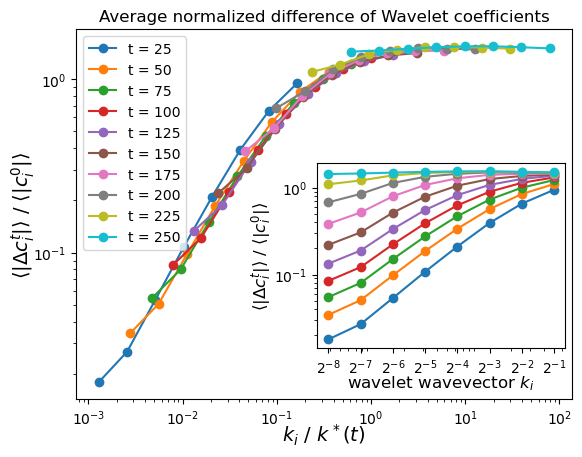

In [25]:
expo_a = 2*1.

fig, ax = plt.subplots()

for it, time_k in enumerate(sorted(values_per_time.keys())):
    k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
    l_star = 1 / k_star
    wave_length = 2**8 / lengths_per_time[time_k]
    wave_vec = 1 / wave_length
    # ax.loglog(2*lengths_per_time[time_k]*l_star, values_per_time[time_k], 'o-', color=f'C{it}', label=f't = {time_k}')
    ax.loglog(wave_vec / k_star, values_per_time[time_k], 'o-', color=f'C{it}', label=f't = {time_k}')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xticks([2**i for i in range(8)], [f'$2^{i}$' for i in range(8)])
ax.set_xlabel('$k_i\ /\ k^*(t)$', fontsize = 14, labelpad=-4)
ax.set_ylabel(f'$\\langle |\Delta c_i^t| \\rangle$ / $\\langle |c_i^0| \\rangle$', rotation=90, labelpad=-3, fontsize = 14)

inset_ax = inset_axes(ax, width="50%", height="50%", loc='lower right', bbox_to_anchor=(-0.0, 0.12, 1, 1), bbox_transform=ax.transAxes)
for it, time_k in enumerate(sorted(values_per_time.keys())):
    # inset_ax.loglog(2*lengths_per_time[time_k], values_per_time[time_k], 'o-', color=f'C{it}')
    inset_ax.loglog(wave_vec, values_per_time[time_k], 'o-', color=f'C{it}')

inset_ax.set_xticks([2**(-i) for i in range(1,9)], ['$2^{-1}$', '$2^{-2}$', '$2^{-3}$', '$2^{-4}$', '$2^{-5}$', '$2^{-6}$', '$2^{-7}$', '$2^{-8}$'])
inset_ax.set_xlabel('wavelet wavevector $k_i$', labelpad=-2, fontsize = 12)
inset_ax.set_ylabel(f'$\\langle |\Delta c_i^t| \\rangle$ / $\\langle |c_i^0| \\rangle$', rotation=90, labelpad=-0, fontsize = 12)


ax.legend(loc=2)
ax.set_title('Average normalized difference of Wavelet coefficients')
# plt.savefig(f'../../plots/forw_back_corr-abs_wavelet_coefficients-inset.png', dpi = 300, bbox_inches='tight')
plt.show()


In [62]:
dict_Lev = defaultdict(list)
times = []

for kk in values_per_time.keys():
    times.append(kk)
    for ik, kv in enumerate(values_per_time[kk]):
        dict_Lev[ik].append(kv)

times = np.array(times)
alphas = alpha_bar[times-1]

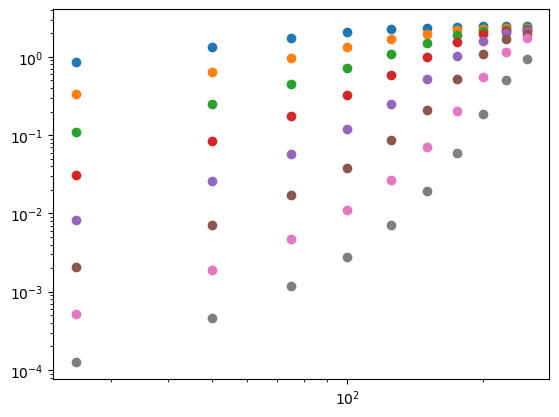

In [7]:
expo_a = 2*1.25
for time_k in values_per_time.keys():
    k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
    l_star = 1 / k_star
    for ik, kv in enumerate(values_per_time[time_k]):
        plt.loglog(time_k/2**0, kv, 'o', color=f'C{ik}')
        # plt.loglog(l_star, kv, 'o', color=f'C{ik}')
        # plt.loglog(k_star, kv, 'o', color=f'C{ik}')

Text(0, 0.5, '$\\langle |c^t_{i} - c^0_{i}| \\rangle / \\langle |c^0_{i}| \\rangle$')

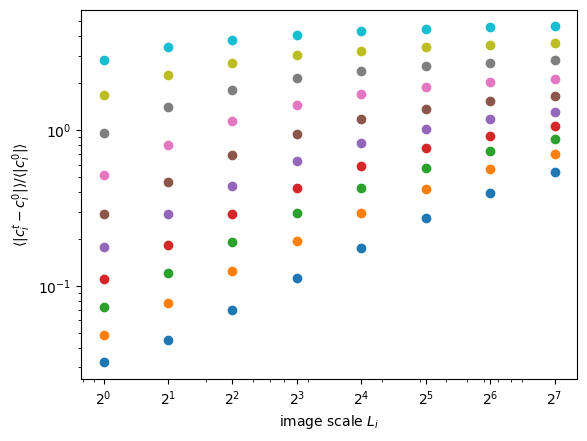

In [6]:
expo_a = 2*1.25
for it, time_k in enumerate(sorted(values_per_time.keys())):
    # k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
    # l_star = 1 / k_star
    for ik, kv in enumerate(values_per_time[time_k]):
        Len = 2**(7-ik)
        plt.loglog(Len, kv, 'o', color=f'C{it}')
        # plt.loglog(l_star, kv, 'o', color=f'C{ik}')
        # plt.loglog(k_star, kv, 'o', color=f'C{ik}')
plt.xticks([2**i for i in range(8)], [f'$2^{i}$' for i in range(8)])
plt.xlabel('image scale $L_i$')
plt.ylabel("$\\langle |c^t_{i} - c^0_{i}| \\rangle / \\langle |c^0_{i}| \\rangle$")

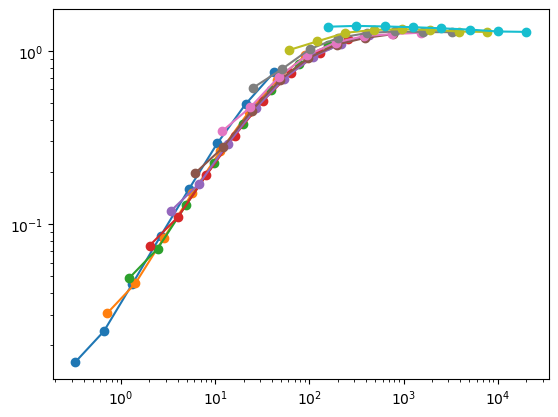

In [20]:
expo_a=2*1.
for it, time_k in enumerate(sorted(values_per_time.keys())):
    k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
    l_star = 1 / k_star
    # for ik, kv in enumerate(values_per_time[time_k]):
        # plt.loglog(2**(7-ik)*l_star, kv, 'o-', color=f'C{it}')
    plt.loglog(lengths_per_time[time_k]*l_star, values_per_time[time_k], 'o-', color=f'C{it}', label=f't = {time_k}')
        # plt.loglog(l_star, kv, 'o', color=f'C{ik}')
        # plt.loglog(k_star, kv, 'o', color=f'C{ik}')

In [5]:
kv

1.4370795

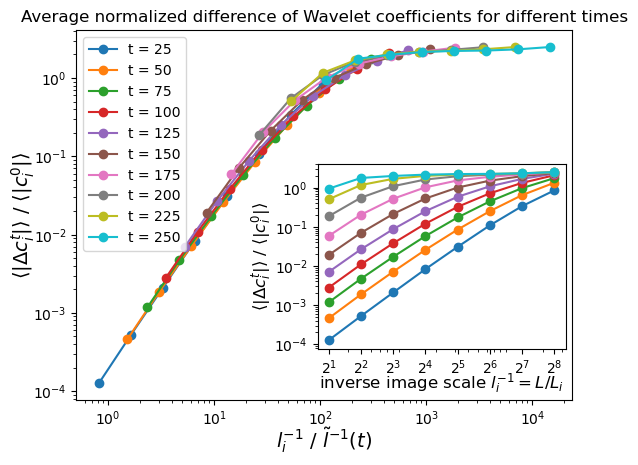

In [72]:
# data_per_time = defaultdict(list)

expo_a = 2*1.25
lengths = 2**(8-np.arange(8))

fig, ax = plt.subplots()

for it, time_k in enumerate(sorted(values_per_time.keys())):
    k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
    l_star = 1 / k_star
    ax.loglog(lengths*l_star, values_per_time[time_k], 'o-', color=f'C{it}', label=f't = {time_k}')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xticks([2**i for i in range(8)], [f'$2^{i}$' for i in range(8)])
ax.set_xlabel('$l_i^{-1}\ /\ \\tilde{l}^{-1}(t)$', fontsize = 14, labelpad=-2)
ax.set_ylabel(f'$\\langle |\Delta c_i^t| \\rangle$ / $\\langle |c_i^0| \\rangle$', rotation=90, labelpad=-3, fontsize = 14)
# move the ylabel
# inset_ax.yaxis.set_label_position("right")

inset_ax = inset_axes(ax, width="50%", height="50%", loc='lower right', bbox_to_anchor=(-0.0, 0.12, 1, 1), bbox_transform=ax.transAxes)
for it, time_k in enumerate(sorted(values_per_time.keys())):
    inset_ax.loglog(lengths, values_per_time[time_k], 'o-', color=f'C{it}')
# for it, time_k in enumerate(sorted(values_per_time.keys())):
#     for ik, kv in enumerate(values_per_time[time_k]):
#         Len = 2**(7-ik)
#         inset_ax.loglog(Len, kv, 'o', color=f'C{it}')
inset_ax.set_xticks([2**i for i in range(1,9)], [f'$2^{i}$' for i in range(1,9)])
inset_ax.set_xlabel('inverse image scale $l_i^{-1} = L/L_i$', labelpad=-4, fontsize = 12)
# inset_ax.set_ylabel("$\\langle |c^t_{i} - c^0_{i}| \\rangle / \\langle |c^0_{i}| \\rangle$")
inset_ax.set_ylabel(f'$\\langle |\Delta c_i^t| \\rangle$ / $\\langle |c_i^0| \\rangle$', rotation=90, labelpad=-0, fontsize = 12)

# inset_ax = inset_axes(ax, width="50%", height="50%", loc='lower right', bbox_to_anchor=(-0.0, 0.12, 1, 1), bbox_transform=ax.transAxes)
# for it, time_k in enumerate(sorted(values_per_time.keys())):
#     k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
#     l_star = 1 / k_star
#     for ik, kv in enumerate(values_per_time[time_k]):
#         inset_ax.loglog(2**(7-ik)*l_star, kv, 'o', color=f'C{it}')
# inset_ax.set_xscale('log')
# inset_ax.set_yscale('log')
# inset_ax.set_xlabel('$\|k\|$', labelpad = -8, fontsize = 14)
# inset_ax.set_ylabel(f'$\\langle |\Delta c_k^t| \\rangle$ / $\\langle |c_k^0| \\rangle$', rotation=90, labelpad=-3, fontsize = 14)
# # move the ylabel
# # inset_ax.yaxis.set_label_position("right")

ax.legend(loc=2)
ax.set_title('Average normalized difference of Wavelet coefficients for different times')
# plt.savefig(f'../../plots/forw_back_corr-mean_wavelet_coefficients-inset.png', dpi = 300, bbox_inches='tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Average normalized difference of Wavelet coefficients for different times')

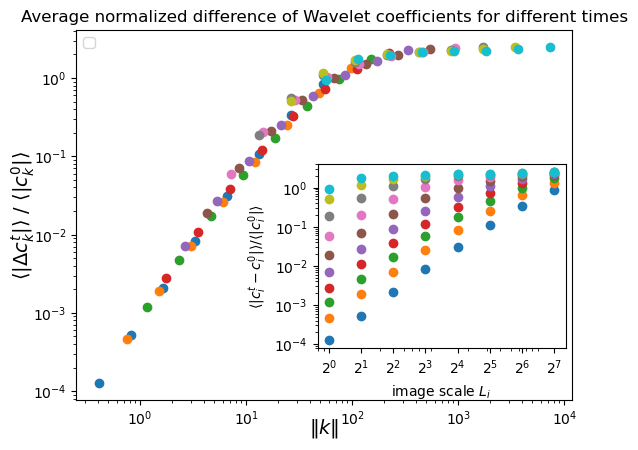

In [16]:
expo_a = 2*1.25

fig, ax = plt.subplots()
for it, time_k in enumerate(sorted(values_per_time.keys())):
    k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
    l_star = 1 / k_star
    for ik, kv in enumerate(values_per_time[time_k]):
        ax.loglog(2**(7-ik)*l_star, kv, 'o', color=f'C{it}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\|k\|$', labelpad = -8, fontsize = 14)
ax.set_ylabel(f'$\\langle |\Delta c_k^t| \\rangle$ / $\\langle |c_k^0| \\rangle$', rotation=90, labelpad=-3, fontsize = 14)
# move the ylabel
# inset_ax.yaxis.set_label_position("right")

inset_ax = inset_axes(ax, width="50%", height="50%", loc='lower right', bbox_to_anchor=(-0.0, 0.12, 1, 1), bbox_transform=ax.transAxes)
for it, time_k in enumerate(sorted(values_per_time.keys())):
    for ik, kv in enumerate(values_per_time[time_k]):
        Len = 2**(7-ik)
        inset_ax.loglog(Len, kv, 'o', color=f'C{it}')
inset_ax.set_xticks([2**i for i in range(8)], [f'$2^{i}$' for i in range(8)])
inset_ax.set_xlabel('image scale $L_i$')
inset_ax.set_ylabel("$\\langle |c^t_{i} - c^0_{i}| \\rangle / \\langle |c^0_{i}| \\rangle$")

# inset_ax = inset_axes(ax, width="50%", height="50%", loc='lower right', bbox_to_anchor=(-0.0, 0.12, 1, 1), bbox_transform=ax.transAxes)
# for it, time_k in enumerate(sorted(values_per_time.keys())):
#     k_star = (alpha_bar[time_k-1]**(-1) - 1)**(-1/expo_a)
#     l_star = 1 / k_star
#     for ik, kv in enumerate(values_per_time[time_k]):
#         inset_ax.loglog(2**(7-ik)*l_star, kv, 'o', color=f'C{it}')
# inset_ax.set_xscale('log')
# inset_ax.set_yscale('log')
# inset_ax.set_xlabel('$\|k\|$', labelpad = -8, fontsize = 14)
# inset_ax.set_ylabel(f'$\\langle |\Delta c_k^t| \\rangle$ / $\\langle |c_k^0| \\rangle$', rotation=90, labelpad=-3, fontsize = 14)
# # move the ylabel
# # inset_ax.yaxis.set_label_position("right")

ax.legend(loc=2)
ax.set_title('Average normalized difference of Wavelet coefficients for different times')


In [9]:
for cc in wavelet_coeff['mean_delta_ck']:
    print(cc.shape)

(12, 128, 128)
(12, 64, 64)
(12, 32, 32)
(12, 16, 16)
(12, 8, 8)
(12, 4, 4)
(12, 2, 2)
(12, 1, 1)


In [28]:
file_args = '../datasets/diffused_ILSVRC2012_validation/t_25_250_args_2024-01-19-23-29-10-184671.pk'
with open(file_args, 'rb') as f:
    args = pickle.load(f)
print(args)

_, diffusion = create_model_and_diffusion(
    **args_to_dict(args, model_and_diffusion_defaults().keys())
)

betas = np.array(diffusion.betas)
alpha_bar = np.array(diffusion.alphas_cumprod)

Namespace(clip_denoised=True, num_samples=10000, batch_size=32, use_ddim=False, model_path='models/256x256_diffusion_uncond.pt', image_size=256, num_channels=256, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=64, attention_resolutions='32,16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=True, use_fp16=True, use_new_attention_order=False, learn_sigma=True, diffusion_steps=1000, noise_schedule='linear', timestep_respacing='250', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False, step_reverse=25, data_dir='/scratch/izar/sclocchi/datasets/ILSVRC2012/validation', output='/scratch/izar/sclocchi/guided-diffusion/results/diffused_ILSVRC2012_validation', num_per_class=10, num_classes=1000)


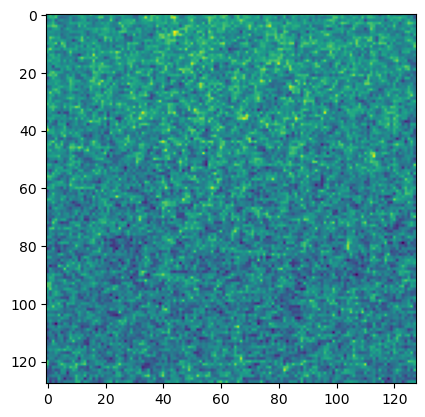

In [16]:
plt.imshow(np.linalg.norm(wavelet_coeff['mean_delta_ck'][0], axis=0))

In [21]:
key = 'mean_abs_delta_ck'
np.linalg.norm(wavelet_coeff[key][0], axis=0).min(), np.linalg.norm(wavelet_coeff[key][0], axis=0).max()

(0.16546978, 0.2161009)

In [22]:
for t in range(25, 275, 25):
    print(t)

25
50
75
100
125
150
175
200
225
250
